In [4]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score

from aif360.datasets import GermanDataset
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

from IPython.display import Markdown, display
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

### Read modelling dataset

In [5]:
orig_dataset = GermanDataset(protected_attribute_names=['sex', 'age'])

In [6]:
# fix labels to be 0s and 1s
# originally, 2 = bad credit, 1 = good credit
orig_dataset.labels = np.where(orig_dataset.labels == 2, 0, 1)

In [7]:
orig_dataset.unfavorable_label = 0.0

In [8]:
# check whether it's resampled
df_og = orig_dataset.convert_to_dataframe()[0]
df_og['credit'].value_counts()

1.0    700
0.0    300
Name: credit, dtype: int64

In [9]:
# 70:30 split into train, test
# 50:50 split of test into valid, test
dataset_train, dataset_vt = orig_dataset.split([0.7], shuffle=True)
dataset_valid, dataset_test = dataset_vt.split([0.5], shuffle=True)

### Modelling: Decision Tree, Random Forests

#### Train

#### Decision Tree vs Random Forest

In [10]:
# setup training data
X_train = dataset_train.features
y_train = dataset_train.labels.ravel()
w_train = dataset_train.instance_weights.ravel()

# train decision tree
tree = DecisionTreeClassifier(random_state=786).fit(X_train, y_train)
tree_y_train_pred = tree.predict(X_train)

# train random forest
forest = RandomForestClassifier(random_state=786).fit(X_train, y_train)
forest_y_train_pred = forest.predict(X_train)

In [11]:
tree.get_depth()

19

In [12]:
# plt.figure(figsize=(8,10))
# plot_tree(tree, filled=True, fontsize=10, feature_names=orig_dataset.feature_names,
#          class_names=['low_risk_group', 'high_risk_group'])
# plt.show()

In [13]:
# fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20,2))

# for n in range(0,10):
#     plot_tree(forest[n], filled=True, feature_names=orig_dataset.feature_names,
#               class_names=['low_risk_group', 'high_risk_group'], ax=axes[n])

# plt.show()

In [14]:
# dataset_train --> dataset_train_pred
dataset_train_pred = dataset_train.copy()
dataset_train_pred.labels = tree_y_train_pred

#### Valid

In [15]:
# dataset_valid --> dataset_valid_pred
dataset_valid_pred = dataset_valid.copy(deepcopy=True)
X_valid = dataset_valid_pred.features
y_valid = dataset_valid_pred.labels

# get preds for obs being in risk group 1
# NOTE: tree probabilities are 0s or 1s
pos_ind = 1
dataset_valid_pred.scores = tree.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
tree_y_valid_pred = dataset_valid_pred.scores

#### Test

In [16]:
# dataset_test --> dataset_test_pred
dataset_test_pred = dataset_test.copy(deepcopy=True)
X_test = dataset_test_pred.features
y_test = dataset_test_pred.labels

# get preds for obs being in risk group 1
pos_ind = 1
dataset_test_pred.scores = tree.predict_proba(X_test)[:,pos_ind].reshape(-1,1)
tree_y_test_pred = dataset_test_pred.scores

In [21]:
# predict probas
tree_y_valid_pred = tree.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
forest_y_valid_pred = forest.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

In [22]:
# NOTE: doesn't work with floats, so need to convert into int values (not int arr)
print(accuracy_score(y_valid.astype(int), tree_y_valid_pred.astype(int)), 
      accuracy_score(y_valid.astype(int), forest_y_valid_pred.astype(int)))

0.6733333333333333 0.32666666666666666


### Optimize n_estimators, max_features, max_impurity, min_impurity_split

In [23]:
len(orig_dataset.feature_names)

58

In [24]:
list_of_params = {
    'max_depth': {'start': 1, 'stop': 251, 'step': 10},
    'min_impurity_split': {'start': 0.51, 'stop': 0.01, 'step': -0.01},
    'max_features': {'start': 1, 'stop': len(orig_dataset.feature_names), 'step': 1},
    'min_impurity_decrease': {'start': 0.05, 'stop': 0.0001, 'step': -0.001}
}

In [25]:
for param in list_of_params.keys():
    start = list_of_params[param]['start']
    stop = list_of_params[param]['stop']
    step = list_of_params[param]['step']
    
    param_arr = np.arange(start, stop, step)
    n_samples = np.int(round((stop-start)/step, 0))
    
    print("Tuning %s" %param)
    
    if param == 'max_depth':    
        ba_arr_depth = np.zeros(n_samples)
        param_arr_depth = np.zeros(n_samples)
        depth_arr_depth = np.zeros(n_samples)
        
        for idx, val in tqdm(enumerate(param_arr)):
            new_tree = DecisionTreeClassifier(max_depth=val).fit(X_train, y_train)
            new_tree_y_valid_pred = new_tree.predict(X_valid).reshape(-1,1)

            ba_arr_depth[idx], param_arr_depth[idx], depth_arr_depth[idx] = balanced_accuracy_score(y_valid, new_tree_y_valid_pred), val, new_tree.get_depth()

    elif param == 'min_impurity_split':
        ba_arr_imp_split = np.zeros(n_samples)
        param_arr_imp_split = np.zeros(n_samples)
        depth_arr_imp_split = np.zeros(n_samples)

        for idx, val in tqdm(enumerate(param_arr)):
            new_tree = DecisionTreeClassifier(min_impurity_split=val).fit(X_train, y_train)
            new_tree_y_valid_pred = new_tree.predict(X_valid).reshape(-1,1)

            ba_arr_imp_split[idx], param_arr_imp_split[idx], depth_arr_imp_split[idx] = balanced_accuracy_score(y_valid, new_tree_y_valid_pred), val, new_tree.get_depth()

    elif param == 'max_features':
        ba_arr_features = np.zeros(n_samples)
        param_arr_features = np.zeros(n_samples)
        depth_arr_features = np.zeros(n_samples)

        for idx, val in tqdm(enumerate(param_arr)):
            new_tree = DecisionTreeClassifier(max_features=val).fit(X_train, y_train)
            new_tree_y_valid_pred = new_tree.predict(X_valid).reshape(-1,1)

            ba_arr_features[idx], param_arr_features[idx], depth_arr_features[idx] = balanced_accuracy_score(y_valid, new_tree_y_valid_pred), val, new_tree.get_depth()

    elif param == 'min_impurity_decrease':
        ba_arr_imp_dec = np.zeros(n_samples)
        param_arr_imp_dec = np.zeros(n_samples)
        depth_arr_imp_dec = np.zeros(n_samples)

        for idx, val in tqdm(enumerate(param_arr)):
            new_tree = DecisionTreeClassifier(min_impurity_decrease=val).fit(X_train, y_train)
            new_tree_y_valid_pred = new_tree.predict(X_valid).reshape(-1,1)

            ba_arr_imp_dec[idx], param_arr_imp_dec[idx], depth_arr_imp_dec[idx] = balanced_accuracy_score(y_valid, new_tree_y_valid_pred), val, new_tree.get_depth()
            
            

25it [00:00, 170.48it/s]
0it [00:00, ?it/s]

Tuning max_depth
Tuning min_impurity_split


50it [00:00, 252.60it/s]
34it [00:00, 336.84it/s]

Tuning max_features


57it [00:00, 268.69it/s]
50it [00:00, 360.00it/s]

Tuning min_impurity_decrease


### Visualize 

In [26]:
sns.set()

In [27]:
def plot_tree_arr(parameter_arr, accuracy_arr, metric_arr, param, metric_name=None):
    if metric_name == None:
        metric_name = 'Tree Depth'
    
    fig, ax1 = plt.subplots(figsize=(8,6))

    ax1.plot(parameter_arr, accuracy_arr, c='tab:orange')
    ax1.set_ylim([0.49,1.01])
    ax1.set_xlabel(param, fontsize=14)
    ax1.set_ylabel('Balanced Accuracy', fontsize=14, c='tab:orange')
    ax1.set_title('Relationship between %s and Balanced Accuracy \n and %s' % (param, metric_name), size=14)

    ax2 = plt.twinx()
    ax2.plot(parameter_arr, metric_arr, c='tab:blue')
    ax2.set_ylabel(metric_name, c='tab:blue', fontsize=14, rotation=-90, labelpad=15)
    
    plt.show()

#### Decision Tree

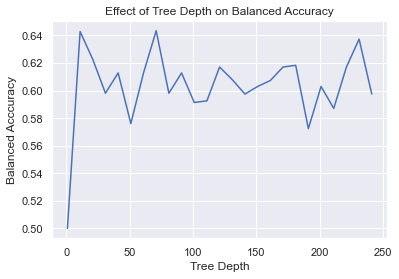

In [28]:
plt.plot(param_arr_depth, ba_arr_depth)
plt.title('Effect of Tree Depth on Balanced Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Balanced Acccuracy')
plt.show()

In [29]:
best_depth = param_arr_depth[np.where(ba_arr_depth == np.max(ba_arr_depth))[0][0]]

In [30]:
print("Balanced Accuracy is maximized at a Tree Depth of %s. However, it's possible that so many trees lead to \noverfitting." % best_depth)



Balanced Accuracy is maximized at a Tree Depth of 71.0. However, it's possible that so many trees lead to 
overfitting.


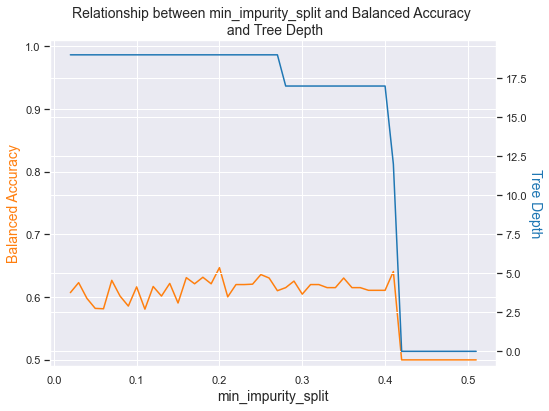

In [31]:
plot_tree_arr(param_arr_imp_split, ba_arr_imp_split, depth_arr_imp_split, param='min_impurity_split')

In [32]:
best_imp_split = param_arr_imp_split[np.where(ba_arr_imp_split == np.max(ba_arr_imp_split))[0][0]]

In [33]:
best_imp_split_depth = depth_arr_imp_split[np.where(ba_arr_imp_split == np.max(ba_arr_imp_split))[0][0]]

In [34]:
print("Balanced Accuracy is maximized when min_impurity_split = %f with a tree depth of %s. When min_impurity_split > ~0.3, there are too few splits leading to underfitting." % (best_imp_split, best_imp_split_depth))



Balanced Accuracy is maximized when min_impurity_split = 0.200000 with a tree depth of 19.0. When min_impurity_split > ~0.3, there are too few splits leading to underfitting.


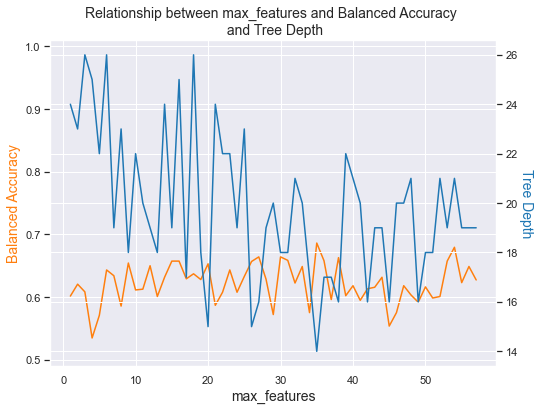

In [35]:
plot_tree_arr(param_arr_features, ba_arr_features, depth_arr_features, param='max_features')

In [36]:
best_features = param_arr_features[np.where(ba_arr_features == np.max(ba_arr_features))[0][0]]

In [37]:
best_features_depth = depth_arr_features[np.where(ba_arr_features == np.max(ba_arr_features))[0][0]]

In [38]:
print("Overall, increasing the number of max_features improves Balanced Accuracy. Balanced Accuracy is maximized when \nmax_features = %s with a tree depth of %s." %(best_features, best_features_depth))


Overall, increasing the number of max_features improves Balanced Accuracy. Balanced Accuracy is maximized when 
max_features = 35.0 with a tree depth of 14.0.


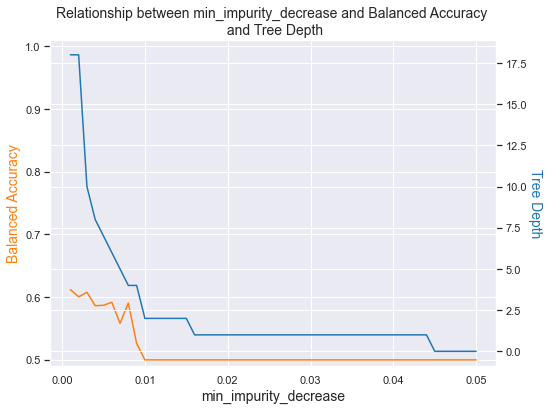

In [39]:
plot_tree_arr(param_arr_imp_dec, ba_arr_imp_dec, depth_arr_imp_dec, param='min_impurity_decrease')

In [40]:
best_imp_dec = param_arr_imp_dec[np.where(ba_arr_imp_dec == np.max(ba_arr_imp_dec))[0][0]]

In [41]:
print("Balanced Accuracy is maximized when min_impurity_decrease = %f." % best_imp_dec)

Balanced Accuracy is maximized when min_impurity_decrease = 0.001000.


#### Random Forest

In [42]:
param = 'n_estimators'

# set start, stop, step
start = 1
stop = 201
step = 10

n_samples = np.int(round((stop - start)/step, 0))

param_arr_est = np.arange(start, stop, step)
ba_arr_est = np.zeros(n_samples)
depth_arr_est = np.zeros(n_samples)

for idx, val in tqdm(enumerate(param_arr_est)):    
    new_forest = RandomForestClassifier(n_estimators=val).fit(X_train, y_train)
    new_forest_y_valid_pred = new_forest.predict(X_valid)
    
    ba_arr_est[idx], param_arr_est[idx], depth_arr_est[idx] = balanced_accuracy_score(y_valid, new_forest_y_valid_pred), val, len(new_forest.estimators_)
    
    

20it [00:04,  4.12it/s]


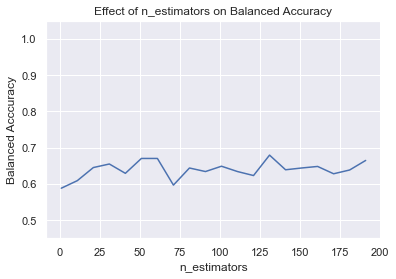

In [43]:
plt.plot(param_arr_est, ba_arr_est)
plt.title('Effect of n_estimators on Balanced Accuracy')
plt.ylim([0.45,1.05])
plt.xlabel('n_estimators')
plt.ylabel('Balanced Acccuracy')
plt.show()

In [44]:
print("Increasing n_estimators appears to marginally improve Balanced Accuracy, but may lead to overfitting.")

Increasing n_estimators appears to marginally improve Balanced Accuracy, but may lead to overfitting.


### Compute fairness metrics at different values for max_depth

In [45]:
privileged_groups = [{'sex': 1, 'age': 1}]
unprivileged_groups = [{'sex': 0, 'age': 0}]

# select dataset
d1 = dataset_test
d2 = dataset_test_pred

In [46]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr = []
mean_diff_arr = []
avg_odds_arr = []
disp_imp_arr = []
indiv_fair_arr = []

# needs to be the same for original and transformed datasets
param_arr = np.arange(1, 26, 1)

for param in tqdm(param_arr):
    # fit a new decision tree
    new_tree = DecisionTreeClassifier(max_depth=param).fit(X_train, y_train)
    new_tree_y_test_pred = new_tree.predict(X_test).reshape(-1,1)
    # update predictions
    d2.labels = new_tree_y_test_pred
    
    metrics_test = ClassificationMetric(d1, d2,
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)
    
    bal_acc = 0.5*(metrics_test.true_positive_rate()+metrics_test.true_negative_rate())
    bal_acc_arr.append(bal_acc)
    
    mean_diff_arr.append(metrics_test.mean_difference())    
    avg_odds_arr.append(metrics_test.average_odds_difference())
    disp_imp_arr.append(metrics_test.disparate_impact())
    indiv_fair_arr.append(metrics_test.consistency(n_neighbors=5))

#### Predictions from original testing data

100%|██████████| 25/25 [00:00<00:00, 84.08it/s]


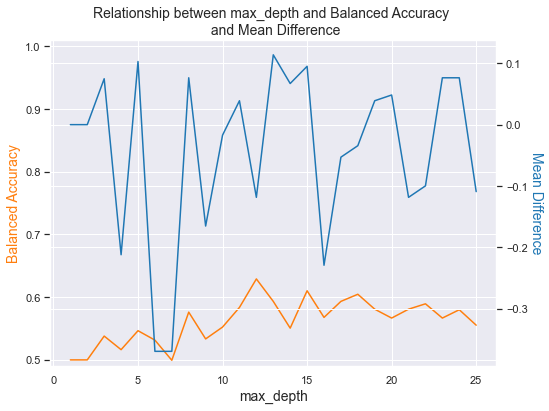

In [47]:
plot_tree_arr(param_arr, bal_acc_arr, mean_diff_arr, param='max_depth', metric_name='Mean Difference')

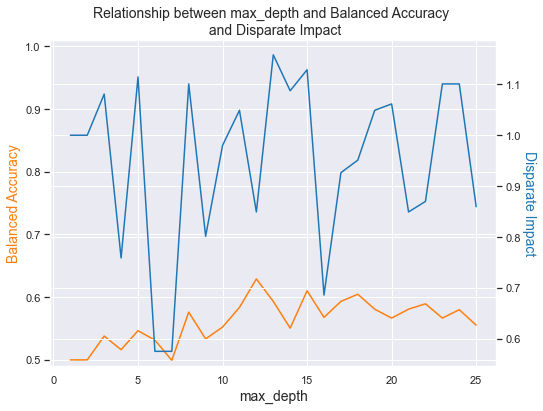

In [48]:
plot_tree_arr(param_arr, bal_acc_arr, disp_imp_arr, param='max_depth', metric_name='Disparate Impact')

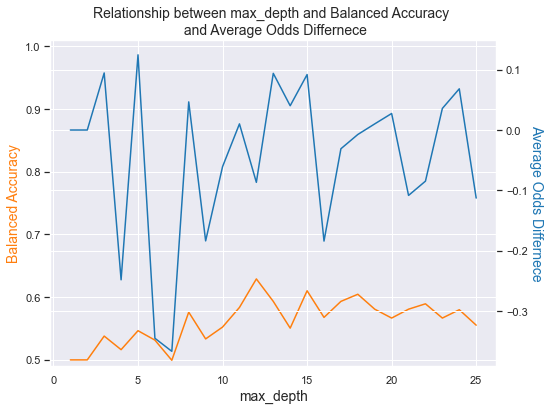

In [49]:
plot_tree_arr(param_arr, bal_acc_arr, avg_odds_arr, param='max_depth', metric_name='Average Odds Differnece')

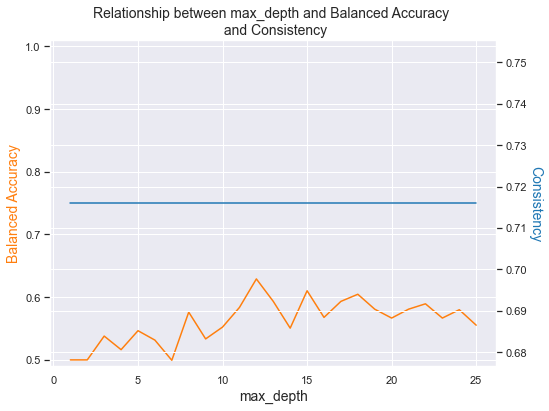

In [50]:
plot_tree_arr(param_arr, bal_acc_arr, indiv_fair_arr, param='max_depth', metric_name='Consistency')

### Train on transformed data

In [56]:
dataset_transf = pd.read_csv('../../data/german-transformed.csv')

In [57]:
dataset_transf = BinaryLabelDataset(df=dataset_transf, label_names=['credit'], 
                             protected_attribute_names=['sex', 'age'],
                             favorable_label=1, unfavorable_label=0)

In [58]:
# 70:30 split into train, test
# 50:50 split of test into valid, test
dataset_transf_train, dataset_transf_test = dataset_transf.split([0.7], shuffle=True)
# dataset_transf_valid, dataset_transf_test = dataset_transf_vt.split([0.5], shuffle=True)

#### Train

In [59]:
X_train_transf = dataset_transf_train.features
y_train_transf = dataset_transf_train.labels.ravel()
w_train_transf = dataset_transf_train.instance_weights.ravel()

tree_transf = DecisionTreeClassifier(random_state=786).fit(X_train, y_train)
tree_y_train_pred = tree_transf.predict(X_train)

#### Test

In [60]:
dataset_transf_test_pred = dataset_transf_test.copy(deepcopy=True)

X_test_transf = dataset_transf_test_pred.features
y_test_transf = dataset_transf_test_pred.labels

# prob of predicting obs to be in risk group 1
pos_ind = 1
dataset_transf_test_pred.scores = tree_transf.predict_proba(X_test_transf)[:,pos_ind].reshape(-1,1)
y_test_preds_transf = dataset_transf_test_pred.scores

In [61]:
# select dataset
d1 = dataset_transf_test
d2 = dataset_transf_test_pred

In [62]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
mean_diff_arr_transf = []
avg_odds_arr_transf = []
disp_imp_arr_transf = []
indiv_fair_arr_transf = []

for param in tqdm(param_arr):
    # fit a new decision tree
    new_tree = DecisionTreeClassifier(max_depth=param).fit(X_train_transf, y_train_transf)
    new_tree_y_test_pred_transf = new_tree.predict(X_test_transf).reshape(-1,1)
    # update predictions
    d2.labels = new_tree_y_test_pred_transf
    
    metrics_test = ClassificationMetric(d1, d2,
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)
    
    bal_acc = 0.5*(metrics_test.true_positive_rate()+metrics_test.true_negative_rate())
    bal_acc_arr_transf.append(bal_acc)
    
    mean_diff_arr_transf.append(metrics_test.mean_difference())    
    avg_odds_arr_transf.append(metrics_test.average_odds_difference())
    disp_imp_arr_transf.append(metrics_test.disparate_impact())
    indiv_fair_arr_transf.append(metrics_test.consistency(n_neighbors=5))

#### Predictions from transformed testing data

100%|██████████| 25/25 [00:00<00:00, 68.48it/s]


### Visualize tradeoffs

In [63]:
sns.set()

In [64]:
def plot_tradeoffs(thresholds_array, accuracy_array, fairness_array, transformed_fairness_array, ax, name):
    ax.plot(thresholds_array, accuracy_array)
    ax.set_xlabel('Decision Tree Depth', fontsize=10.5)
    ax.set_ylabel('Balanced Accuracy', color='b', fontsize=12, labelpad=15)
    # best_class_thresh used as global variable
    # ax.axvline(best_class_thresh, color='k', linestyle=':')

    ax1 = ax.twinx()
    ax1.plot(thresholds_array, fairness_array, color='r', alpha=0.5)
    ax1.set_ylabel(name, color='r', fontsize=12, rotation=-90, labelpad=15)
    ax1.plot(thresholds_array, transformed_fairness_array, color='r')
    
    ax.set_title(name, fontsize=16)
    ax1.legend(['Original', 'Transformed'], loc='lower left')
    ax1.grid(True)

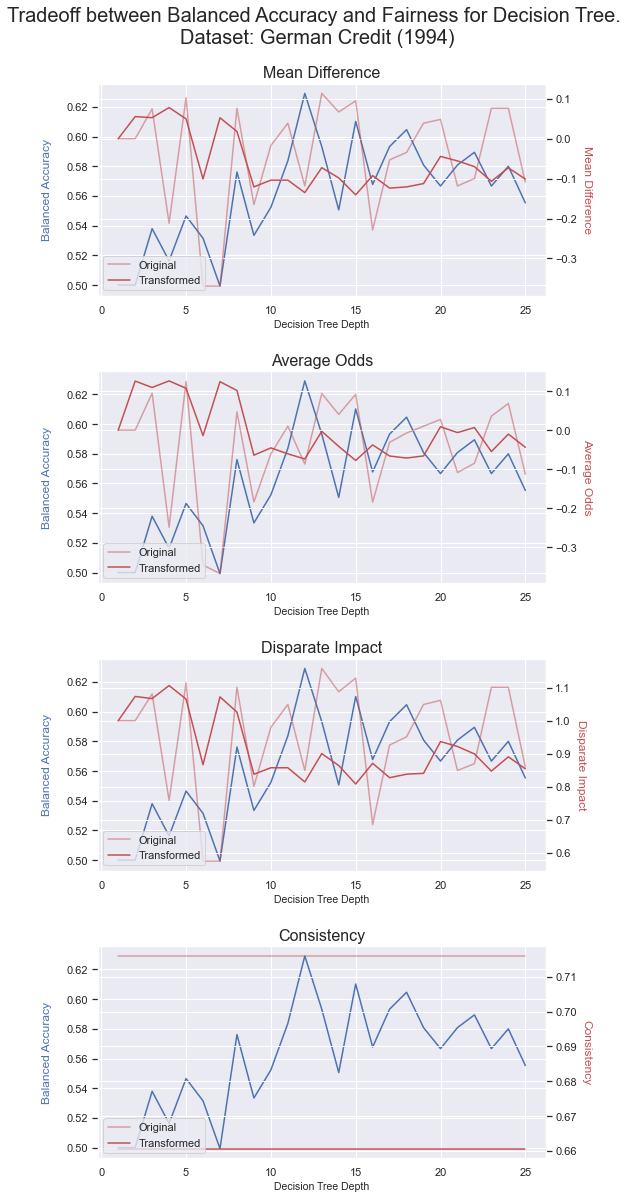

In [65]:
fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(8,16))

plot_tradeoffs(param_arr, bal_acc_arr, mean_diff_arr, mean_diff_arr_transf, ax=ax[0], name='Mean Difference')

plot_tradeoffs(param_arr, bal_acc_arr, avg_odds_arr, avg_odds_arr_transf, ax=ax[1], name='Average Odds')

plot_tradeoffs(param_arr, bal_acc_arr, disp_imp_arr, disp_imp_arr_transf, ax=ax[2], name='Disparate Impact')

plot_tradeoffs(param_arr, bal_acc_arr, indiv_fair_arr, indiv_fair_arr_transf, ax=ax[3], name='Consistency')

fig.tight_layout(h_pad=2, w_pad=2.5)
fig.suptitle('Tradeoff between Balanced Accuracy and Fairness for Decision Tree. \nDataset: German Credit (1994)', 
             x=0.5, y=1.04, size=20)
plt.show()